In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
def get_embeddings_vectors_curated_data(folder_path):
    # Initialize a list to store the vectors
    embeddings = {}

    # Traverse through each folder in the specified directory
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            # Check if the file is a .pt file
            if file.endswith('.pt'):
                file_path = os.path.join(root, file)
                embedding = torch.load(file_path)
                embeddings[embedding["label"]] = embedding["representations"][6]

    return embeddings

embeddings_dict = get_embeddings_vectors_curated_data('curated_dataset/example_embeddings_esm2_reduced_input')
print("embeddings_dict len", (embeddings_dict["A0A1X7AIY7.1/282-340"]).shape)
print("embeddings_dict", embeddings_dict["A0A1X7AIY7.1/282-340"])
len("STPIRIFANGRRRVEVLRDNRLIYATSVNAGSQEIDTSSFPQGSYQLTIRIFNGSTLEQ")

embeddings_dict len torch.Size([59, 320])
embeddings_dict tensor([[-0.6685, -0.0708, -0.5033,  ...,  0.8954,  0.4106, -0.5340],
        [-0.6899, -0.1052,  0.0013,  ...,  0.5112, -0.0517, -0.3438],
        [-0.5972, -0.1812,  0.3029,  ...,  0.4339,  0.3076, -0.0928],
        ...,
        [-0.2558, -0.0050,  0.2232,  ...,  0.4575, -0.0603, -0.1484],
        [-0.3865, -0.1068,  0.3723,  ...,  0.4398, -0.3131, -0.0656],
        [-0.1832,  0.3298,  0.3563,  ..., -0.0673, -0.4823, -0.1598]])


59

In [5]:
len('QIGGEDKADIAPILKEGFVGPGMQINNLLQERGEIVATVICGDNYFNENLDEATDTILGMIGQFNPDIVIAGPSFNAGRYGMACGAVCKAVSEKFNIPTLTGMYIESPGVDGYRKYTYIVETANSAVGMRTALPAMVKLALKLVDGVELGDPKEEGYIARGVRRNYFHAVRGSKRAVDMLIAKINDQPFTTEYPMPTFDRVAPNPHIVDMSKATIALVTSGGIVPKGNPDHIESSSASKFGKYDIEGFTNLTEKTHETAHGGYDPVYANLDADRVLPVDVLRELEAEGVIGKLHRYFYTTVGNGTSVANAKKFAAAIGKELVEAKVDAVILTST')

334

In [6]:
def get_conservation_scores(csv_file):
    # Charger le CSV
    df = pd.read_csv(csv_file, delimiter=',', names=[
                     'sequence id', 'conservation score'], header=0)

    sequences = df['sequence id'].values
    conservation_scores = df['conservation score'].apply(lambda x: np.array(
    [float(i) if i != 'nan' else 0.0 for i in x.split()], dtype=np.float32)).values
    #print("conservation_scores", conservation_scores)

    return sequences, conservation_scores

sequences, conservation_scores_tensors = get_conservation_scores('curated_dataset/reduced_input.csv')

In [7]:
conservation_scores_tensors[1].shape

(152,)

Epoch 1/5:
loss tensor(0.3399, grad_fn=<MseLossBackward0>)
loss tensor(0.0966, grad_fn=<MseLossBackward0>)
loss tensor(0.1242, grad_fn=<MseLossBackward0>)
loss tensor(0.0898, grad_fn=<MseLossBackward0>)
loss tensor(0.1548, grad_fn=<MseLossBackward0>)
loss tensor(0.1613, grad_fn=<MseLossBackward0>)
loss tensor(0.0275, grad_fn=<MseLossBackward0>)
loss tensor(0.0385, grad_fn=<MseLossBackward0>)
loss tensor(0.1825, grad_fn=<MseLossBackward0>)
loss tensor(0.0456, grad_fn=<MseLossBackward0>)
loss tensor(0.0647, grad_fn=<MseLossBackward0>)
loss tensor(0.1934, grad_fn=<MseLossBackward0>)
loss tensor(0.0378, grad_fn=<MseLossBackward0>)
loss tensor(0.0548, grad_fn=<MseLossBackward0>)
loss tensor(0.0758, grad_fn=<MseLossBackward0>)
loss tensor(0.0292, grad_fn=<MseLossBackward0>)
loss tensor(0.0889, grad_fn=<MseLossBackward0>)
loss tensor(0.0439, grad_fn=<MseLossBackward0>)
loss tensor(0.0390, grad_fn=<MseLossBackward0>)
loss tensor(0.0303, grad_fn=<MseLossBackward0>)
loss tensor(0.0403, grad_fn=<

/home/patyarakawa/mi_entorno/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 160])) that is different to the input size (torch.Size([1, 160, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/patyarakawa/mi_entorno/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 95])) that is different to the input size (torch.Size([1, 95, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/patyarakawa/mi_entorno/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 200])) that is different to the input size (torch.Size([1, 200, 1])). This will likely lead to incorrect results due to broadc

loss tensor(0.0789, grad_fn=<MseLossBackward0>)
loss tensor(0.0353, grad_fn=<MseLossBackward0>)
loss tensor(0.0612, grad_fn=<MseLossBackward0>)
loss tensor(0.0399, grad_fn=<MseLossBackward0>)
loss tensor(0.0314, grad_fn=<MseLossBackward0>)
loss tensor(0.0590, grad_fn=<MseLossBackward0>)
loss tensor(0.0318, grad_fn=<MseLossBackward0>)
loss tensor(0.0539, grad_fn=<MseLossBackward0>)
loss tensor(0.0355, grad_fn=<MseLossBackward0>)
loss tensor(0.0593, grad_fn=<MseLossBackward0>)
loss tensor(0.0684, grad_fn=<MseLossBackward0>)
loss tensor(0.0342, grad_fn=<MseLossBackward0>)
loss tensor(0.0707, grad_fn=<MseLossBackward0>)
loss tensor(0.0605, grad_fn=<MseLossBackward0>)
loss tensor(0.0877, grad_fn=<MseLossBackward0>)
loss tensor(0.0274, grad_fn=<MseLossBackward0>)
loss tensor(0.0612, grad_fn=<MseLossBackward0>)
loss tensor(0.0578, grad_fn=<MseLossBackward0>)
loss tensor(0.0533, grad_fn=<MseLossBackward0>)
loss tensor(0.0455, grad_fn=<MseLossBackward0>)
loss tensor(0.0765, grad_fn=<MseLossBack

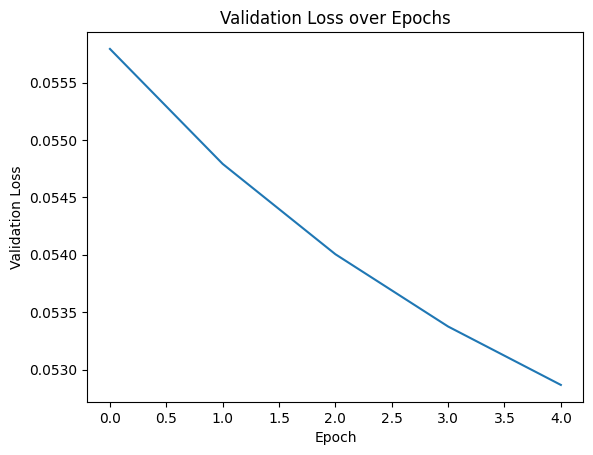

In [10]:
# Fonction pour obtenir les embeddings correspondant aux séquences
def get_embeddings(sequences, embeddings_dict):
    embeddings = []
    for sequence_id in sequences:
        embedding = embeddings_dict[sequence_id]
        print(embedding)
        embeddings.append(embedding)
    embeddings = torch.stack(embeddings)
    return embeddings

def get_embedding(sequence_id, embeddings_dict):
    return embeddings_dict[sequence_id]


# Fonction pour entraîner le modèle en utilisant la descente de gradient stochastique (SGD)
def train_model_stochastic(model, optimizer, loss_fn, sequences, conservation_scores):
    model.train()
    for i in range(len(sequences)):
        sequence_id = sequences[i]
        if i == len(sequences) - 1:
            print("sequence_id", sequence_id)
            print("embedding", embedding)
        embedding = get_embedding(sequence_id, embeddings_dict)
        #embedding_tensor = torch.tensor(embedding, dtype=torch.float32)
        label = torch.tensor(conservation_scores[i], dtype=torch.float32)

        optimizer.zero_grad()
        output = model(embedding)

        
        loss = loss_fn(output.squeeze(), label)
        print("loss", loss)
        loss.backward()
        optimizer.step()
        if i == len(sequences) - 1 or False:
            print("label", label.shape)
            print("label", label)
            print("embedding", embedding.shape)
            print("embedding", embedding)
            print("output", output.shape)
            print("output", output)
            



# Définir le modèle de régression linéaire

class LinearRegression(nn.Module):
    def __init__(self, input_size):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)



# Évaluation du modèle sur l'ensemble de validation
def evaluate_model(model, loss_fn, data_loader):
    running_loss = 0.

    with torch.no_grad():
        for i, data in enumerate(data_loader):
            inputs, labels = data

            outputs = model(inputs)

            loss = loss_fn(outputs, labels)

            running_loss += loss.item()

    return running_loss / len(data_loader)

# Configuration des hyperparamètres
learning_rate = 0.001
num_epochs = 5
batch_size = 1


# Créer l'ensemble de données
dataset = [(embeddings_dict[sequence], conservation_scores) for sequence, conservation_scores in zip(sequences, conservation_scores_tensors)]
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Créer les data loaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)



# Initialiser le modèle, la fonction de perte et l'optimiseur
model = LinearRegression(input_size=320)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

val_losses = []
# Entraînement du modèle
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}:')
    model.train()
    train_model_stochastic(model, optimizer, loss_fn,
                           sequences[:100], conservation_scores_tensors[:100])

    # Validation du modèle
    model.eval()
    val_loss = evaluate_model(model, loss_fn, val_loader)
    val_losses.append(val_loss) 
    #print(f'Validation Loss: {val_loss}')
# on trace la perte de validation au fil des époques
plt.plot(val_losses)
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss over Epochs')
plt.show()

In [9]:
# Cargar el archivo .pt
embedding = torch.load('curated_dataset/example_embeddings_esm2_reduced_input/A0A1I4YI28.1/1-164.pt')

# Ahora puedes acceder al tensor del embedding
print(embedding["representations"][6])


tensor([[ 0.1827,  0.4544,  0.0703,  ...,  0.9286, -0.1682,  0.0573],
        [-0.0597, -0.0637,  0.7307,  ...,  0.3019,  0.2616,  0.5997],
        [ 0.1731, -0.0389,  0.8230,  ...,  0.5839, -0.2457,  0.3610],
        ...,
        [-0.0797,  0.2541,  0.7844,  ...,  0.5837,  0.1552,  0.1666],
        [ 0.2382, -0.3610,  0.6018,  ..., -0.0876, -0.3903,  0.0103],
        [-0.0087, -0.5144,  0.2969,  ..., -0.0461, -0.0331,  0.4260]])
